In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal
from data_subplot import data_subplot

from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals

%matplotlib inline

In [2]:


# SYNC
def build_bcg_df(bcg_values, initial_timestamp, fs):
    """
    Constructs a BCG DataFrame from raw values, initial timestamp, and sampling rate.
    
    Args:
        bcg_values: List of BCG signal values (e.g., [-86, -90, -91, -86])
        initial_timestamp: Timestamp of first sample (epoch ms or datetime string)
        fs: Sampling frequency in Hz
        
    Returns:
        pd.DataFrame with columns: ['Timestamp', 'BCG', 'Time']
    """
    # Convert timestamp to datetime if it's a string
    if isinstance(initial_timestamp, str):
        initial_timestamp = pd.to_datetime(initial_timestamp)
    elif isinstance(initial_timestamp, (int, float)):
        initial_timestamp = pd.to_datetime(initial_timestamp, unit='ms')
    
    # Calculate time intervals
    period = 1 / fs
    timestamps = [initial_timestamp + pd.Timedelta(seconds=i*period) 
                 for i in range(len(bcg_values))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'BCG': bcg_values
    })
    
    # Add human-readable time
    df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f')
    
    return df




def synchronize_bcg_and_hr(df_bcg_raw, df_hr_raw):
    """
    Builds and synchronizes BCG and HR DataFrames starting from the first common time.
    
    Args:
        df_bcg_raw: Raw BCG DataFrame from CSV. Must contain 'BCG', 'Timestamp', and 'fs' columns.
        df_hr_raw: Raw HR DataFrame from CSV. Must contain 'Timestamp' column in datetime-compatible format.
    
    Returns:
        bcg_aligned, hr_aligned: Time-synchronized DataFrames
    """
        # Parse BCG values and metadata
    bcg_values = df_bcg_raw['BCG'].tolist()
    initial_timestamp = pd.to_datetime(df_bcg_raw.loc[0, 'Timestamp'], unit='ms')
    fs = float(df_bcg_raw.loc[0, 'fs'])

    # Build BCG DataFrame
    df_bcg = build_bcg_df(bcg_values, initial_timestamp, fs)

    # Parse HR timestamps
    df_hr_raw['Timestamp'] = pd.to_datetime(df_hr_raw['Timestamp'])

    # Find common time range
    start_time = max(df_bcg['Timestamp'].min(), df_hr_raw['Timestamp'].min())
    end_time = min(df_bcg['Timestamp'].max(), df_hr_raw['Timestamp'].max())

    # Trim both DataFrames to common range
    bcg_aligned = df_bcg[(df_bcg['Timestamp'] >= start_time) & (df_bcg['Timestamp'] <= end_time)].copy()
    hr_aligned = df_hr_raw[(df_hr_raw['Timestamp'] >= start_time) & (df_hr_raw['Timestamp'] <= end_time)].copy()

    # Reset index
    bcg_aligned.reset_index(drop=True, inplace=True)
    hr_aligned.reset_index(drop=True, inplace=True)

    return bcg_aligned, hr_aligned






In [3]:

#read csv files
df_bcg= pd.read_csv('/home/bahey/bio_data/dataset/data/01/BCG/01_20231105_BCG.csv')        #### n4 &
df_heart=pd.read_csv("/home/bahey/bio_data/dataset/data/01/Reference/RR/01_20231105_RR.csv")   #### 1 second one

# step 1 :Synchronize BCG and HR DataFrames from the first common time
bcg_sync, hr_sync = synchronize_bcg_and_hr(df_bcg, df_heart)

print("Time synchronized BCG DataFrame:")
print(bcg_sync.head())
print("\nTime synchronized Heart Rate DataFrame:")
print(hr_sync.head())


Time synchronized BCG DataFrame:
                      Timestamp  BCG             Time
0 2023-11-04 19:12:20.003285714  -60  19:12:20.003285
1 2023-11-04 19:12:20.010428571  -65  19:12:20.010428
2 2023-11-04 19:12:20.017571428 -101  19:12:20.017571
3 2023-11-04 19:12:20.024714285  -59  19:12:20.024714
4 2023-11-04 19:12:20.031857142  -15  19:12:20.031857

Time synchronized Heart Rate DataFrame:
            Timestamp  Heart Rate  RR Interval in seconds
0 2023-11-04 19:12:20          99                   0.613
1 2023-11-04 19:12:20          99                   0.621
2 2023-11-04 19:12:21          98                   0.626
3 2023-11-04 19:12:22          98                   0.632
4 2023-11-04 19:12:22          98                   0.635


In [4]:
hr_sync['Timestamp'] = pd.to_datetime(hr_sync['Timestamp'])

# Set Timestamp as the index
hr_sync.set_index('Timestamp', inplace=True)

# Group by 10-second windows and compute both mean and count
windowed_df = hr_sync.resample('15S').agg({
    'Heart Rate': ['mean', 'count']
})

# Optional: flatten MultiIndex columns
windowed_df.columns = ['HR_mean', 'HR_count']

# Print the result
print(windowed_df)


                       HR_mean  HR_count
Timestamp                               
2023-11-04 19:12:15  98.687500        16
2023-11-04 19:12:30  98.541667        24
2023-11-04 19:12:45  92.956522        23
2023-11-04 19:13:00  92.800000        20
2023-11-04 19:13:15  92.826087        23
...                        ...       ...
2023-11-04 22:04:45  58.800000        15
2023-11-04 22:05:00  59.333333        15
2023-11-04 22:05:15  59.933333        15
2023-11-04 22:05:30  60.066667        15
2023-11-04 22:05:45  59.571429         7

[695 rows x 2 columns]


/tmp/ipykernel_32811/1930026416.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  windowed_df = hr_sync.resample('15S').agg({


In [5]:
# resample bcg to 50 hz 
bcg_sync.set_index('Timestamp', inplace=True)

# Original sampling rate (140 Hz)
fs_original = 140  
# Target sampling rate (50 Hz)
fs_target = 50  

# Calculate resampling factor
resample_factor = fs_target / fs_original

# Number of samples in resampled signal
num_samples = int(len(bcg_sync) * resample_factor)

# Resample the BCG signal using Fourier method (preserves timing information)
resampled_bcg = signal.resample(bcg_sync['BCG'], num_samples)

# Create new timestamps for the resampled data
start_time = bcg_sync.index[0]
end_time = bcg_sync.index[-1]
new_timestamps = pd.date_range(start=start_time, end=end_time, periods=num_samples)

# Create new DataFrame with resampled data
resampled_df = pd.DataFrame({
    'BCG': resampled_bcg,
    'Time': new_timestamps.time
}, index=new_timestamps)

# Reset index if you want Timestamp as a column again
resampled_df.reset_index(inplace=True)
resampled_df.rename(columns={'index': 'Timestamp'}, inplace=True)

print(resampled_df.head())

                      Timestamp         BCG             Time
0 2023-11-04 19:12:20.003285714  -62.199690  19:12:20.003285
1 2023-11-04 19:12:20.023285755  -51.919848  19:12:20.023285
2 2023-11-04 19:12:20.043285796 -125.002844  19:12:20.043285
3 2023-11-04 19:12:20.063285837 -811.109988  19:12:20.063285
4 2023-11-04 19:12:20.083285878 -414.326722  19:12:20.083285


In [6]:
total =len(resampled_df)/500
total = int(total)
print(total)

1041


Data stream length: 520581


/tmp/ipykernel_32811/451351055.py:3: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds


Bad windows: [ 45  90  91  95  96 149 150 151 152 187 188 189 202 204 229 278 295 301
 302 365 366 370 375 399 400 421 495 549 552 553 554 616 617 626 627 630
 633 639 640 644 662 674 680 681 687 689 690 691 693]


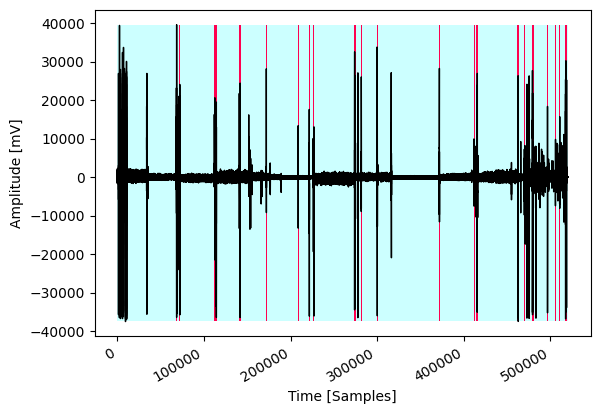

In [7]:
bcg = resampled_df
start_point, end_point, window_shift, fs = 0, 750, 750, 50
bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds
utc_time = bcg['epoch']
data_stream = bcg['BCG']
print("Data stream length:", len(data_stream))
data_stream, utc_time, bad_windows  = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
print("Bad windows:", bad_windows)

In [8]:
print(data_stream)
print(utc_time)

1         -51.919848
2        -125.002844
3        -811.109988
4        -414.326722
5        -106.564291
             ...    
520576    -25.777328
520577    -31.191030
520578    -28.447707
520579    -34.915308
520580    -25.351139
Name: BCG, Length: 520531, dtype: float64
1         1699125140023
2         1699125140043
3         1699125140063
4         1699125140083
5         1699125140103
              ...      
520576    1699135551544
520577    1699135551564
520578    1699135551584
520579    1699135551604
520580    1699135551624
Name: epoch, Length: 520531, dtype: int64


Wavelet Cycle Length: 520531


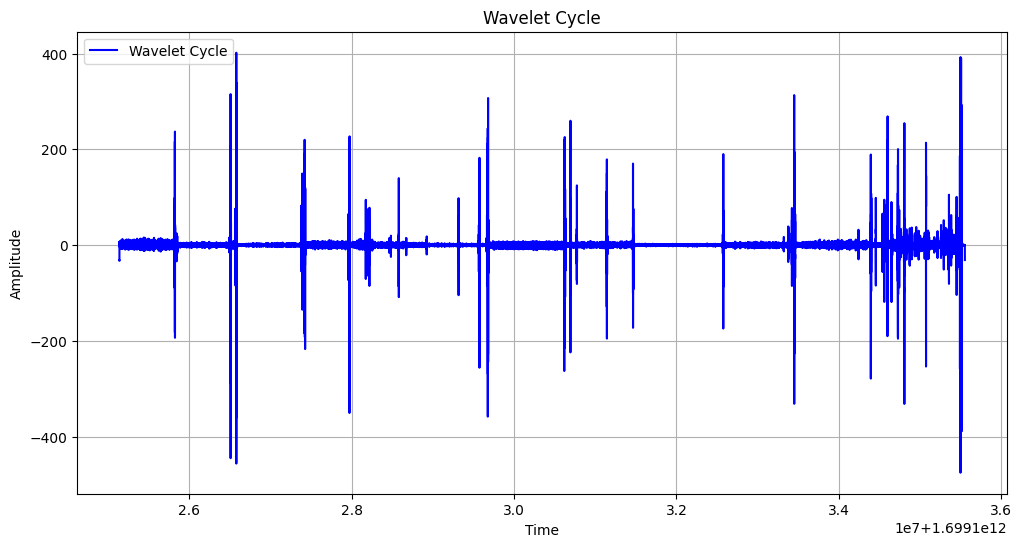

In [9]:
movement = band_pass_filtering(data_stream, fs, "bcg")
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
print("Wavelet Cycle Length:", len(wavelet_cycle))
# plot the wavelet cycle
plt.figure(figsize=(12, 6))
plt.plot(utc_time, wavelet_cycle, label='Wavelet Cycle', color='blue')
plt.title('Wavelet Cycle')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [10]:
t1, t2, window_length, window_shift = 0, 750, 750, 750
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time.values, mpd=1, plot=0)  # utc_time.values in seconds 


In [11]:
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))

Minimum pulse :  64.0
Maximum pulse :  103.0
Average pulse :  85.0


In [12]:
hr_sync.index = pd.to_datetime(hr_sync.index)

# Resample into non-overlapping 10-second windows and compute mean HR
mean_hr_df = hr_sync.resample('15S').mean(numeric_only=True).dropna().reset_index()

# Select and rename columns
mean_hr_df = mean_hr_df[['Timestamp', 'Heart Rate']].rename(
    columns={'Timestamp': 'Window Start', 'Heart Rate': 'Mean HR'}
)
mean_hr_df

/tmp/ipykernel_32811/3140345879.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  mean_hr_df = hr_sync.resample('15S').mean(numeric_only=True).dropna().reset_index()


,Window Start,Mean HR
0,2023-11-04 19:12:15,98.687500
1,2023-11-04 19:12:30,98.541667
2,2023-11-04 19:12:45,92.956522
3,2023-11-04 19:13:00,92.800000
4,2023-11-04 19:13:15,92.826087
...,...,...
690,2023-11-04 22:04:45,58.800000
691,2023-11-04 22:05:00,59.333333
692,2023-11-04 22:05:15,59.933333
693,2023-11-04 22:05:30,60.066667


In [13]:
filtered_array = np.delete(beats, bad_windows, axis=0)
len(filtered_array)

645

In [16]:
# drop from beats and mean_hr_df the indices in bad windows
existing_bad_windows = [idx for idx in bad_windows if idx in mean_hr_df.index]
filtered_df = mean_hr_df.drop(index=existing_bad_windows)
filtered_df

,Window Start,Mean HR
0,2023-11-04 19:12:15,98.687500
1,2023-11-04 19:12:30,98.541667
2,2023-11-04 19:12:45,92.956522
3,2023-11-04 19:13:00,92.800000
4,2023-11-04 19:13:15,92.826087
...,...,...
685,2023-11-04 22:03:30,59.166667
686,2023-11-04 22:03:45,58.230769
688,2023-11-04 22:04:15,58.066667
692,2023-11-04 22:05:15,59.933333


In [18]:
# error calculation
y_true = filtered_df['Mean HR'].values
y_pred = filtered_array
min_len = min(len(y_true), len(y_pred))

# Trim both to the same length from the end
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_true - y_pred))

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Mean Absolute Percentage Error (MAPE)
# Add small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 10.294
RMSE: 12.248
MAPE: 13.83%
